Importing Dependencies and using Tensorflow as Deep Learning API

In [0]:
import os
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook, tnrange
import zipfile

In [0]:
%matplotlib inline
sns.set()

Extracting all the pickle files to current directory

In [0]:
with open("train_image.pkl", "rb") as f:
    train_images = pickle.load(f)

with open("test_image.pkl", "rb") as f:
    test_images = pickle.load(f)

with open("train_label.pkl", "rb") as f:
    train_labels = pickle.load(f)

submission_df = pd.read_csv("hitkul(sample_submission).csv")

In [0]:
num_classes = 4
train_labels = np.array([1 if i==6 else i for i in train_labels])
labels = np.zeros((len(train_labels), num_classes), dtype=np.int32)
labels[np.arange(len(train_labels)), train_labels] = 1

Reshaping input images to perform convolution operation

In [0]:
train_images = np.reshape(train_images, [-1, 28, 28, 1])
test_images = np.reshape(test_images, [-1, 28, 28, 1])

In [25]:
submission_df.head()

,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


Describing Basic Utility function<br>
conv2d: function for convolution operation<br>
fc: function for fully connected layer<br>
dataset_batch: batch generator function for training and evaluation

In [0]:
def conv2d(x, out_channels, ksize, stride, padding):
    in_shape = x.get_shape().as_list()
    in_channels = in_shape[-1]
    w = tf.get_variable(name="w", shape=[ksize, ksize, in_channels, out_channels], dtype=tf.float32, 
                            initializer=tf.truncated_normal_initializer(mean=0., stddev=np.sqrt(1/(in_shape[1]*in_shape[2]))))
    b = tf.get_variable(name="b", shape=[out_channels], dtype=tf.float32, 
                        initializer=tf.random_uniform_initializer(minval=0., maxval=0.1))
    return tf.nn.relu(tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding=padding) + b)

def fc(x, out, activation):
    in_shape = x.get_shape().as_list()
    w = tf.get_variable(name="w", shape=[in_shape[-1], out], dtype=tf.float32, 
                       initializer=tf.truncated_normal_initializer(mean=0., stddev=np.sqrt(1/in_shape[-1])))
    b = tf.get_variable(name="b", shape=[out], dtype=tf.float32, 
                       initializer=tf.random_uniform_initializer(minval=0., maxval=0.1))
    return activation(tf.matmul(x, w) + b)

def dataset_batch(images, batch_size, labels=None, shuffle=True):
    if shuffle:
        shuff_ind = np.random.permutation(len(images))
        images = images[shuff_ind]
        if labels is not None:
            labels = labels[shuff_ind]
    for i in range(len(images)//batch_size):
        imgs = images[i*batch_size: i*batch_size+batch_size]
        if labels is not None:
            lbls = labels[i*batch_size: (i+1)*batch_size]
            yield imgs, lbls
        else:
            yield imgs
    return

Creating a CNN model with five layers <br>
Four Convoulution Layers and one fully connected layer<br>
Using Adam Optimizer as optimizer

In [0]:
tf.reset_default_graph()

input_plh = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name="inputs")
label_plh = tf.placeholder(dtype=tf.int32, shape=[None, num_classes], name="labels")

with tf.variable_scope("Convolution1"):
    conv = conv2d(input_plh, 64, 3, 1, "SAME")
mp = tf.nn.max_pool(conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")

with tf.variable_scope("Convolution2"):
    conv = conv2d(mp, 128, 3, 1, "SAME")

with tf.variable_scope("Convolutio3"):
    conv = conv2d(conv, 128, 3, 1, "SAME")
mp = tf.nn.max_pool(conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")

with tf.variable_scope("Convolution4"):
    conv = conv2d(mp, 256, 3, 1, "SAME")
flattened = tf.reshape(conv, [-1, 7*7*256])

with tf.variable_scope("FullyConnected"):
    logits = fc(flattened, num_classes, lambda x: x)

pred_prob = tf.nn.softmax(logits)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=label_plh))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred_prob, axis=1), tf.argmax(label_plh, axis=1)), dtype=tf.float32))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Training and Evaluation process

In [28]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    accuracies = []
    for epoch in tnrange(50):
        acc_list = []
        loss_list = []
        gen = dataset_batch(train_images, 200, labels)
        for imgs, lbls in tqdm_notebook(gen):
            _, loss_val, acc_val = sess.run([optimizer, loss, accuracy], feed_dict={input_plh: imgs, label_plh: lbls})
            acc_list.append(acc_val)
            loss_list.append(loss_val)
        tqdm.write("Epoch %d completed"%(epoch+1))
        tqdm.write("Average Loss: %f"%float(np.mean(loss_list)))
        tqdm.write("Average Accuracy: %f"%float(np.mean(acc_list)))
        losses.append(np.mean(loss_list))
        accuracies.append(np.mean(acc_list))
    print("Predicting")
    test_labels = []
    gen = dataset_batch(test_images, 100, shuffle=False)
    for imgs in gen:
        pred_val = sess.run(pred_prob, feed_dict={input_plh: imgs})
        pred_val = np.argmax(pred_val, axis=1)
        test_labels.extend(pred_val)

Epoch 1 completed
Average Loss: 38.729633
Average Accuracy: 0.560500


Epoch 2 completed
Average Loss: 0.583084
Average Accuracy: 0.780375


Epoch 3 completed
Average Loss: 0.438876
Average Accuracy: 0.829250


Epoch 4 completed
Average Loss: 0.371892
Average Accuracy: 0.858375


Epoch 5 completed
Average Loss: 0.307032
Average Accuracy: 0.881000


Epoch 6 completed
Average Loss: 0.274064
Average Accuracy: 0.895875


Epoch 7 completed
Average Loss: 0.247540
Average Accuracy: 0.904750


Epoch 8 completed
Average Loss: 0.203955
Average Accuracy: 0.923500


Epoch 9 completed
Average Loss: 0.161921
Average Accuracy: 0.943875


Epoch 10 completed
Average Loss: 0.136644
Average Accuracy: 0.953625


Epoch 11 completed
Average Loss: 0.111350
Average Accuracy: 0.965250


Epoch 12 completed
Average Loss: 0.094622
Average Accuracy: 0.970500


Epoch 13 completed
Average Loss: 0.072478
Average Accuracy: 0.981375


Epoch 14 completed
Average Loss: 0.061838
Average Accuracy: 0.986250


Epoch 15 completed
Average Loss: 0.050609
Average Accuracy: 0.989625


Epoch 16 completed
Average Loss: 0.045956
Average Accuracy: 0.989875


Epoch 17 completed
Average Loss: 0.035609
Average Accuracy: 0.993500


Epoch 18 completed
Average Loss: 0.023351
Average Accuracy: 0.997875


Epoch 19 completed
Average Loss: 0.016874
Average Accuracy: 0.999250


Epoch 20 completed
Average Loss: 0.012847
Average Accuracy: 0.999625


Epoch 21 completed
Average Loss: 0.009403
Average Accuracy: 1.000000


Epoch 22 completed
Average Loss: 0.007423
Average Accuracy: 1.000000


Epoch 23 completed
Average Loss: 0.006141
Average Accuracy: 1.000000


Epoch 24 completed
Average Loss: 0.005328
Average Accuracy: 1.000000


Epoch 25 completed
Average Loss: 0.004454
Average Accuracy: 1.000000


Epoch 26 completed
Average Loss: 0.003893
Average Accuracy: 1.000000


Epoch 27 completed
Average Loss: 0.003378
Average Accuracy: 1.000000


Epoch 28 completed
Average Loss: 0.002979
Average Accuracy: 1.000000


Epoch 29 completed
Average Loss: 0.002710
Average Accuracy: 1.000000


Epoch 30 completed
Average Loss: 0.002494
Average Accuracy: 1.000000


Epoch 31 completed
Average Loss: 0.002244
Average Accuracy: 1.000000


Epoch 32 completed
Average Loss: 0.002069
Average Accuracy: 1.000000


Epoch 33 completed
Average Loss: 0.002034
Average Accuracy: 1.000000


Epoch 34 completed
Average Loss: 0.001846
Average Accuracy: 1.000000


Epoch 35 completed
Average Loss: 0.001664
Average Accuracy: 1.000000


Epoch 36 completed
Average Loss: 0.001504
Average Accuracy: 1.000000


Epoch 37 completed
Average Loss: 0.001418
Average Accuracy: 1.000000


Epoch 38 completed
Average Loss: 0.001331
Average Accuracy: 1.000000


Epoch 39 completed
Average Loss: 0.001245
Average Accuracy: 1.000000


Epoch 40 completed
Average Loss: 0.001133
Average Accuracy: 1.000000


Epoch 41 completed
Average Loss: 0.001103
Average Accuracy: 1.000000


Epoch 42 completed
Average Loss: 0.001034
Average Accuracy: 1.000000


Epoch 43 completed
Average Loss: 0.000970
Average Accuracy: 1.000000


Epoch 44 completed
Average Loss: 0.000886
Average Accuracy: 1.000000


Epoch 45 completed
Average Loss: 0.000853
Average Accuracy: 1.000000


Epoch 46 completed
Average Loss: 0.000796
Average Accuracy: 1.000000


Epoch 47 completed
Average Loss: 0.000737
Average Accuracy: 1.000000


Epoch 48 completed
Average Loss: 0.000714
Average Accuracy: 1.000000


Epoch 49 completed
Average Loss: 0.000662
Average Accuracy: 1.000000


Epoch 50 completed
Average Loss: 0.000638
Average Accuracy: 1.000000
Predicting


Plotting Loss and accuracy chages during training

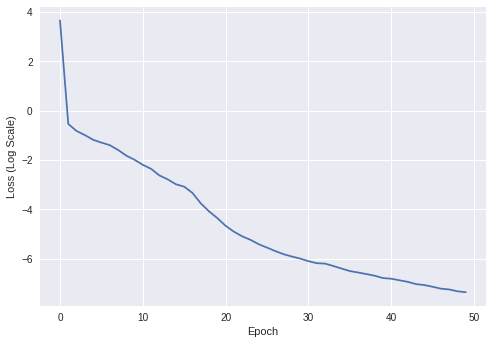

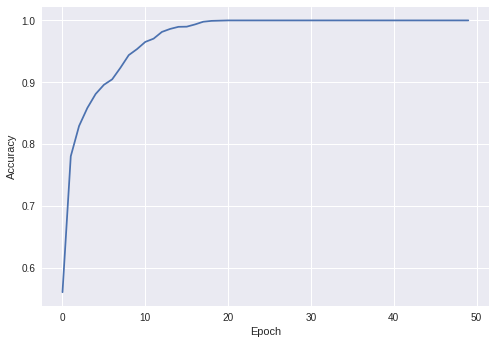

In [29]:
epochs = list(range(50))
plt.plot(epochs, np.log(losses))
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.show()
plt.plot(epochs, accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Generating Final submission file

In [30]:
test_labels = [6 if i==1 else i for i in test_labels]
submission = pd.DataFrame()
submission["image_index"] = list(range(len(test_images)))
submission["class"] = test_labels
submission.to_csv("final.csv", index=False)
submission.head(100)

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [31]:
import collections
counts = collections.Counter(test_labels)
counts.most_common()

[(6, 517), (2, 505), (0, 497), (3, 481)]